# Etape 2 : Modèle de base

- Construction d'une baseline Zero-Shot a partir d'un modèle LLM
- Finetuning de ce modèle à partir du dataset (contrastive loss)

In [1]:
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pickle

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sentence_transformers.quantization import quantize_embeddings
from sentence_transformers import losses
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader

/Users/mbp004/dev/test_yxir/yxir/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### Methode Zero-Shot

On prend un modele du MTEB leaderboard pour realiser les embeddings de documents
On teste le modele suivant : mxbai-embed-large-v1, proposé par mixedbread ai. Le modèle a été entrainé sur la tache de STS (Semantic Textual Similarity)

In [2]:
# 1. Specify preffered dimensions
dimensions = 512

# 2. load model
model_name = 'intfloat/e5-small-v2'
# model_name = "mixedbread-ai/mxbai-embed-large-v1"
model = SentenceTransformer(model_name, truncate_dim=dimensions)


/Users/mbp004/dev/test_yxir/yxir/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Code utilisé sur Hugging Face
# For retrieval you need to pass this prompt.
query = 'Represent this sentence for searching relevant passages: A man is eating a piece of bread'

docs = [
    query,
    "A man is eating food.",
    "A man is eating pasta.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
]

# 2. Encode
embeddings = model.encode(docs)

# Optional: Quantize the embeddings
binary_embeddings = quantize_embeddings(embeddings, precision="ubinary")

similarities = cos_sim(embeddings[0], embeddings[1:])
print('similarities:', similarities)

similarities: tensor([[0.8732, 0.8448, 0.6409, 0.7452]])


### Experience sur le dataset big_patent

On calcule les embeddings brutalement sur les contenus des brevets, abstracts et sur les queries.
Le but est de voir ici si la similarité est plus grande entre la query et l'exemple positif qu'entre la query et le sample négatif

In [4]:
with open('/Users/mbp004/dev/test_yxir/data/dataset_big_patent_v1.json') as f:
    data = json.load(f)

In [5]:
list_all_embeddings = []
for i in tqdm(range(len(data)), desc ="Calcul des embeddings initiaux"):
    query = data[i]['query']
    pos_text = data[i]['pos']
    negative_text = data[i]['negative']
    
    docs = [
        query,
        pos_text,
        negative_text
    ]
    
    embeddings = model.encode(docs)
    list_all_embeddings.append(embeddings)

Calcul des embeddings initiaux: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [06:23<00:00,  1.30it/s]


In [13]:
dic_all_embeddings = {'embeddings': list_all_embeddings}
with open('../data/list_all_embeddings_e5-small-v2.pickle', 'wb') as fh:
    pickle.dump(dic_all_embeddings, fh)
    fh.close()

In [7]:
with open('../data/list_all_embeddings_e5-small-v2.pickle', 'rb') as fh:
    dic_all_embeddings = pickle.load(fh)
    fh.close()
list_all_embeddings = dic_all_embeddings['embeddings']

In [8]:
nb_good_embeddings = 0
for i in range(len(list_all_embeddings)):
    embeddings = list_all_embeddings[i]
    similarities = cos_sim(embeddings[0], embeddings[1:])
    sim_pos, sim_neg = similarities.flatten()
    if sim_pos > sim_neg :
        nb_good_embeddings+=1
perc_good_embeddings = round(100*nb_good_embeddings/len(list_all_embeddings),2)
print('Embeddings de documents compatibles avec la query: {}, {} %'.format(nb_good_embeddings,
                                                                           perc_good_embeddings))

Embeddings de documents compatibles avec la query: 370, 74.15 %


Calcul des similarites: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [01:07<00:00, 14.87it/s]


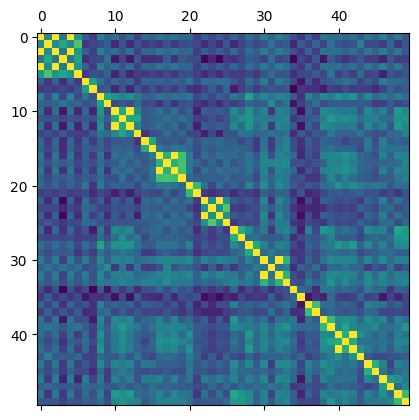

In [9]:
# Heatmap sur les similarites entre contenus de brevet
list_embeddings_heatmap = []
for i in range(len(list_all_embeddings)):
    list_embeddings_heatmap.append(list_all_embeddings[i][1])
    list_embeddings_heatmap.append(list_all_embeddings[i][2])

list_similarities_heatmap = []
for i in tqdm(range(len(list_embeddings_heatmap)), desc ="Calcul des similarites"):
    list_similarities_heatmap_i = []
    for j in range(len(list_embeddings_heatmap)):
        sim = float(cos_sim(list_embeddings_heatmap[i], list_embeddings_heatmap[j]).flatten()[0])
        list_similarities_heatmap_i.append(sim)
    list_similarities_heatmap.append(list_similarities_heatmap_i)
similarity_matrix = np.array(list_similarities_heatmap)

plt.matshow(similarity_matrix[0:50,0:50])
plt.show()

Visuellement sur les embeddings de documents, on voit des carrés autour de la diagonale, ce qui traduit la construction du dataset où des questions successives autour du meme theme sont posees

Calcul des similarites sur les queries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:16<00:00, 30.54it/s]


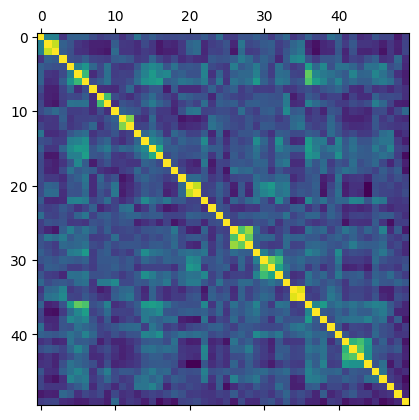

In [10]:
# Heatmap sur les similarites entre queries
list_all_embeddings_queries = []
for i in range(len(list_all_embeddings)):
    list_all_embeddings_queries.append(list_all_embeddings[i][0])

list_similarities_queries_heatmap = []
for i in tqdm(range(len(list_all_embeddings_queries)), desc ="Calcul des similarites sur les queries"):
    list_similarities_heatmap_i = []
    for j in range(len(list_all_embeddings_queries)):
        sim = float(cos_sim(list_all_embeddings_queries[i], list_all_embeddings_queries[j]).flatten()[0])
        list_similarities_heatmap_i.append(sim)
    list_similarities_queries_heatmap.append(list_similarities_heatmap_i)
similarity_matrix_queries = np.array(list_similarities_queries_heatmap)

plt.matshow(similarity_matrix_queries[0:50,0:50])
plt.show()

On voit un peu cet effet sur les embeddings des queries meme si c'est moins flagrant.
A priori ceci est du à : 
- la taille des queries qui est tres faible donc plus facile a disciminer

Les pistes que ça nous amène à regarder : 
- restreindre les documents a certaines sections, pour eviter que le vecteur d'embedding soit noyé dans pleins d'informations
- finetuner le modele avec les données de brevet

### Performances en retrieval

Calcul des performances en retrieval sur une liste d'embeddings de type : 
[[emb_query, emb_pos, emb_neg]...]
On cherche a calculer : 
- le top_K_accuracy sur les labels positifs (a maximiser)
- le top_K_accuracy sur les labels negatifs (a minimiser)

In [35]:
def compute_top_K_accuracy_score(list_embeddings, K=5):
    '''
    Fonction pour calculer le top_K_accuracy score a partir d'une liste d'embeddings de type :
    [[emb_query, emb_pos, emb_neg]...]
    list_embeddings -- list, list des embeddings des query, positive, negative
    K -- int, le top K accuracy
    '''
    list_embeddings_query = [list_embeddings[i][0] for i in range(len(list_all_embeddings))]
    list_embeddings_pos = [list_embeddings[i][1] for i in range(len(list_all_embeddings))]
    list_embeddings_neg = [list_embeddings[i][2] for i in range(len(list_all_embeddings))]
    
    nb_pos = 0
    nb_neg = 0
    for idx in tqdm(range(len(list_embeddings_query)), desc ="Calcul du top_K_accuracy score"):
        query = list_embeddings_query[idx]
        
        similarities_pos = cos_sim(query, list_embeddings_pos).flatten().tolist()
        similarities_pos = [('pos_{}'.format(i), similarities_pos[i]) for i in range(len(similarities_pos))]
        
        similarities_neg = cos_sim(query, list_embeddings_neg).flatten().tolist()
        similarities_neg = [('neg_{}'.format(i), similarities_neg[i]) for i in range(len(similarities_neg))]
        
        similarities = similarities_pos+similarities_neg
        similarities = sorted(similarities, key = lambda x: -x[1])
        top_K_ids = [similarities[i][0] for i in range(K)]
        
        if 'pos_{}'.format(idx) in top_K_ids:
            nb_pos+=1
        if 'neg_{}'.format(idx) in top_K_ids:
            nb_neg+=1
    acc_K_pos = nb_pos/len(list_embeddings)
    acc_K_neg = nb_neg/len(list_embeddings)
    return acc_K_pos, acc_K_neg

acc_K_pos, acc_K_neg = compute_top_K_accuracy_score(list_all_embeddings, K=5)
print('acc_K_pos : {} (a maximiser)'.format(acc_K_pos))
print('acc_K_neg : {} (a minimiser)'.format(acc_K_neg))

Calcul du top_K_accuracy score: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:25<00:00, 19.33it/s]

acc_K_pos : 0.9338677354709419 (a maximiser)
acc_K_neg : 0.7134268537074149 (a minimiser)


### Finetuning du modele

On va tenter de finetuner le modele mxbai-embed-large-v1 sur les exemples de brevets

In [36]:
# Construction du dataset pour le finetuning
train_examples = []
for i in range(len(data)):
    anchor = data[i]['query']
    pos_example = data[i]['pos']
    neg_example = data[i]['negative']
    train_examples.append(InputExample(texts=[anchor, pos_example], label=1))
    train_examples.append(InputExample(texts=[anchor, neg_example], label=0))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)

In [37]:
# Training
train_loss = losses.ContrastiveLoss(model=model)

model.fit(
    [(train_dataloader, train_loss)],
    epochs=10,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

Iteration:   0%|          | 0/499 [00:00<?, ?it/s]

In [38]:
# Recalculer les embeddings
list_all_embeddings_finetuning = []
for i in tqdm(range(len(data)), desc ="Calcul des embeddings apres finetuning"):
    query = data[i]['query']
    pos_text = data[i]['pos']
    negative_text = data[i]['negative']
    
    docs = [
        query,
        pos_text,
        negative_text
    ]
    
    embeddings = model.encode(docs)
    list_all_embeddings_finetuning.append(embeddings)

dic_all_embeddings = {'embeddings': list_all_embeddings_finetuning}
with open('../data/list_all_embeddings_e5-small-v2_finetuning.pickle', 'wb') as fh:
    pickle.dump(dic_all_embeddings, fh)
    fh.close()

Calcul des embeddings apres finetuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [06:20<00:00,  1.31it/s]


In [39]:
# Bonne classification
nb_good_embeddings = 0
for i in range(len(list_all_embeddings_finetuning)):
    embeddings = list_all_embeddings_finetuning[i]
    similarities = cos_sim(embeddings[0], embeddings[1:])
    sim_pos, sim_neg = similarities.flatten()
    if sim_pos > sim_neg :
        nb_good_embeddings+=1
perc_good_embeddings = round(100*nb_good_embeddings/len(list_all_embeddings_finetuning),2)
print('Embeddings de documents compatibles avec la query: {}, {} %'.format(nb_good_embeddings,
                                                                           perc_good_embeddings))

Embeddings de documents compatibles avec la query: 499, 100.0 %


In [40]:
# top_K_accuracy
acc_K_pos, acc_K_neg = compute_top_K_accuracy_score(list_all_embeddings_finetuning, K=5)
print('acc_K_pos : {} (a maximiser)'.format(acc_K_pos))
print('acc_K_neg : {} (a minimiser)'.format(acc_K_neg))

Calcul du top_K_accuracy score: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:24<00:00, 20.68it/s]

acc_K_pos : 0.19438877755511022 (a maximiser)
acc_K_neg : 0.0 (a minimiser)
